# Projet Stratégies d'Investissement Alternatives et Quantitatives
## Jérémy Bellina, Joël Zhu

# Set up all packages and information

In [1]:
# import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# load the csv data
crypto_prices = pd.read_csv("crypto_prices.csv", parse_dates=[0])
crypto_prices.set_index('date', inplace=True)

In [3]:
# create rebalancing dates array
rebalancing_dates = pd.date_range(start = "2018-04-01", end = "2020-05-01", freq = pd.DateOffset(months=1, day = 1))
formatted_dates = pd.date_range(start = "2018-04-01", end = "2020-05-26")

In [147]:
# horizon
horizon = 14

# Helper functions

In [150]:
def sort_returns(current_date, data, past_horizon):
    start_date = str(current_date.date() - pd.to_timedelta(past_horizon, unit='d'))
    end_date = str(current_date.date())
    returns = (data.loc[end_date] - data.loc[start_date])/data.loc[start_date]
    # We sort those returns
    sorted_returns = returns.sort_values(ascending=False)
    
    return sorted_returns

In [38]:
def compute_value(date, portfolio, crypto_prices):
    value = 0
    for item in portfolio:
        value += item[1] * crypto_prices.loc[date, item[0]]
    return value

In [7]:
def update_portfolio(amount, data, date, crypto_names):
    portfolio = []
    for name in crypto_names:
        portfolio.append((name, amount / data.loc[date, name]))
    return portfolio

# Portfolio backtests

Creates portfolio long on all crypto currencies **equally weighted**

In [102]:
def get_portfolio_prices(initial_value, horizon, formatted_dates, rebalancing_dates, data, portfolio_index):
    values = [initial_value]
    for date in formatted_dates:
        if date in rebalancing_dates:
            sorted_returns = sort_returns(date, data, horizon)
            crypto_names = sorted_returns.iloc[(10 * (portfolio_index - 1)):(10 * portfolio_index)].index
            portfolio = update_portfolio(values[-1] / 10, data, date, crypto_names)
        values.append(compute_value(date, portfolio, data))

    return values[1:]

Creates a portfolio **long on best returns** crypto currencies and **short on lowest returns** ones

In [84]:
 def long_short_strategy(ptf_values1, ptf_values5):
    values = []
    for value1, value5 in zip(ptf_values1, ptf_values5):
        values.append(value1 - value5)
    return values

# Plot of portfolios values 

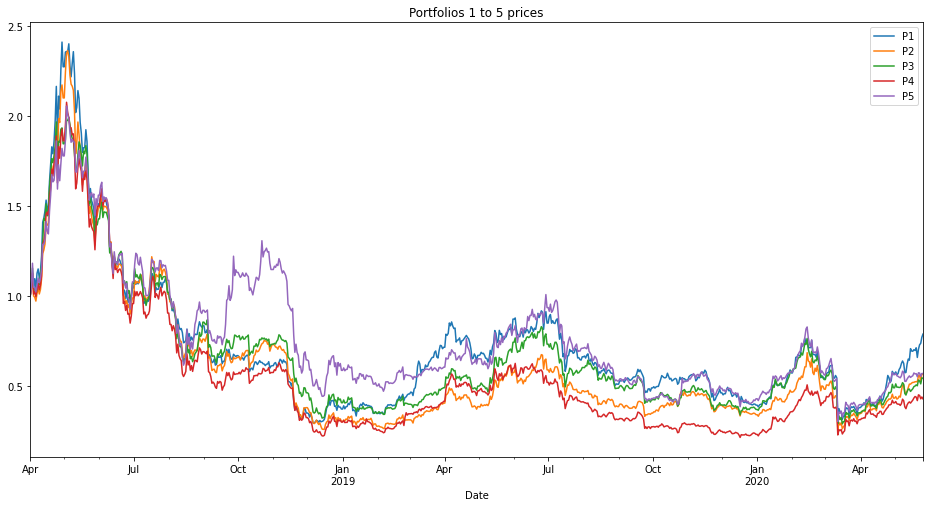

In [151]:
ptf_values1 = get_portfolio_prices(100, horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values2 = get_portfolio_prices(100, horizon, formatted_dates, rebalancing_dates, crypto_prices, 2)
ptf_values3 = get_portfolio_prices(100, horizon, formatted_dates, rebalancing_dates, crypto_prices, 3)
ptf_values4 = get_portfolio_prices(100, horizon, formatted_dates, rebalancing_dates, crypto_prices, 4)
ptf_values5 = get_portfolio_prices(100, horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)

all_ptf_values = pd.DataFrame(data = {'Date': formatted_dates, 'P1': ptf_values1, 'P2': ptf_values2, 'P3': ptf_values3, 'P4': ptf_values4, 'P5': ptf_values5})
all_ptf_values.set_index('Date', inplace=True)

all_ptf_rets = all_ptf_values.pct_change()
all_ptf_rets = 1+ all_ptf_rets
all_ptf_rets.iloc[0,:] = 1
all_ptf_rets = all_ptf_rets.cumprod()

all_ptf_rets.plot(figsize=(16,8), title="Portfolios 1 to 5 prices")

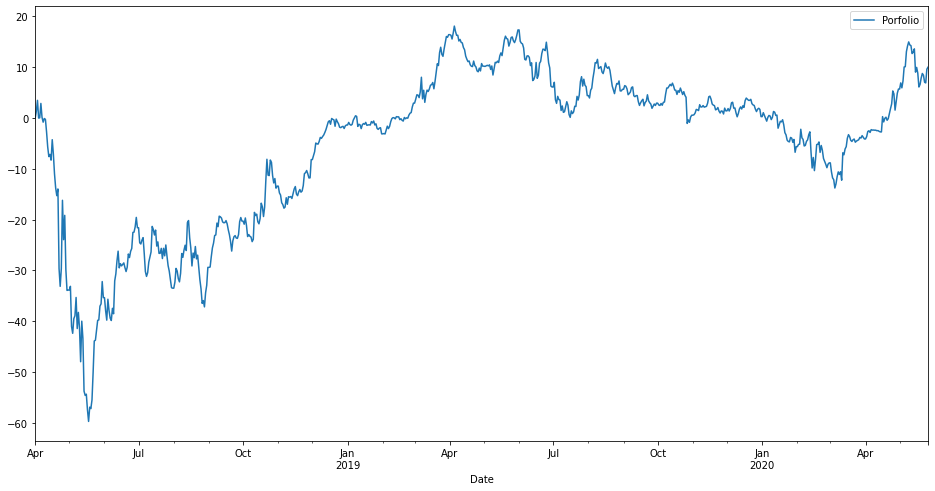

In [142]:
ptf_values1 = get_portfolio_prices(100, horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values5 = get_portfolio_prices(100, horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)
final_values = long_short_strategy(ptf_values1, ptf_values5)

ptf_values = pd.DataFrame(data = {'Date': formatted_dates, 'Porfolio': final_values})
ptf_values.set_index('Date', inplace=True)
ptf_values.plot(figsize=(16,8))